## About the Dataset and Hypothesis Statement

### Dataset Source
The dataset is sourced from [Kaggle](https://www.kaggle.com/datasets/sahasourav17/students-anxiety-and-depression-dataset/data).  
It contains text collected from various social media platforms, including Facebook, Twitter, and others. The data was manually annotated by four undergraduate students.

### Dataset Description
The dataset includes two columns:
- **Text**: Contains posts related to mental health.
- **Labels**: Indicates the emotional state of the post.  
  - `1`: Anxiety/Depression-related text.  
  - `0`: Normal mood text.

### Hypothesis Statement
Social media posts reflect people's mental health states. By analyzing the text, I hypothesize that posts can be clustered into two categories: **depressed** or **healthy**.



## Import Necessary Libraries here

In [1]:
#!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.0 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.9 MB/s eta 0:00:00


In [2]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import string
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, precision_score, classification_report
from transformers import BertTokenizer, BertModel, pipeline, AutoModel, AutoTokenizer
import spacy
import json
import torch

!python -m spacy download en_core_web_lg # Download large English model provided by spaCy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Section 1

## 1. Data Exploration and Preprocessing


### Load and Explore the Data

In [3]:
df = pd.read_excel("./data/dataset.xlsx")
df.head()

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6982 entries, 0 to 6981
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    6972 non-null   object 
 1   label   6980 non-null   float64
dtypes: float64(1), object(1)
memory usage: 109.2+ KB


#### The dataset comprises **6,980 labels** and **6,972 text entries**. To ensure data quality, any rows that contain empty text fields will be dropped.

In [5]:
# drop null rows
df = df.dropna(inplace=False)

# Reset the index
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6970 entries, 0 to 6969
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    6970 non-null   object 
 1   label   6970 non-null   float64
dtypes: float64(1), object(1)
memory usage: 109.0+ KB


#### The label column is currently of type float. Since it represents binary values (0 and 1), it should be converted to an integer type for accuracy and consistency

In [6]:
# change label dtype to int
df['label'] = df['label'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6970 entries, 0 to 6969
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6970 non-null   object
 1   label   6970 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 109.0+ KB


### Investigating the Distribution of Normal and Depressed Texts

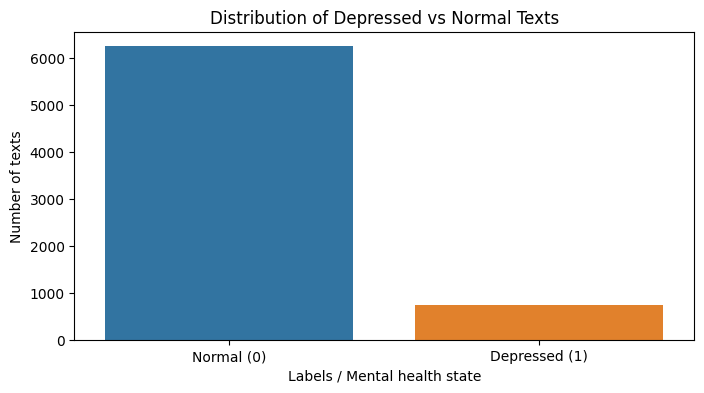

In [7]:
# Visualize the distribution of labels
plt.figure(figsize=(8, 4))

sns.countplot(data=df, x='label', hue='label', legend=False)
plt.xticks(ticks=[0, 1], labels=['Normal (0)', 'Depressed (1)'], rotation=0)
plt.xlabel("Labels / Mental health state")
plt.ylabel("Number of texts")
plt.title("Distribution of Depressed vs Normal Texts");


In [8]:
print("Distribution of depressed(1) and normal(0) texts:")
print(df['label'].value_counts());

Distribution of depressed(1) and normal(0) texts:
label
0    6240
1     730
Name: count, dtype: int64


#### Observations:
- The number of **depressed text** entries is **730**.
- The number of **normal text** entries is **6240**.

This indicates a significant **data imbalance**, with a higher proportion of normal text entries compared to depressed text entries.

### Analyzing the Distribution of Text Lengths

1. **Sentence Count**:  
   - Measure the number of **sentences** in each text entry.

2. **Word Count**:  
   - Calculate the number of **words** in each text entry.

#### Objective:  
This analysis aims to identify the differences in sentence count or text length between **depressed** and **normal** text entries.

### Sentence Count Distribution in Text Data

In [9]:
# Define a function to count number of sentences in a text
def count_sentences(text):
    '''tokenize each text into sentences and returns number of sentences'''
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

In [10]:
# Apply count_sentences function to 'text' column to compute sentence count
df['n_sentences'] = df['text'].apply(count_sentences)

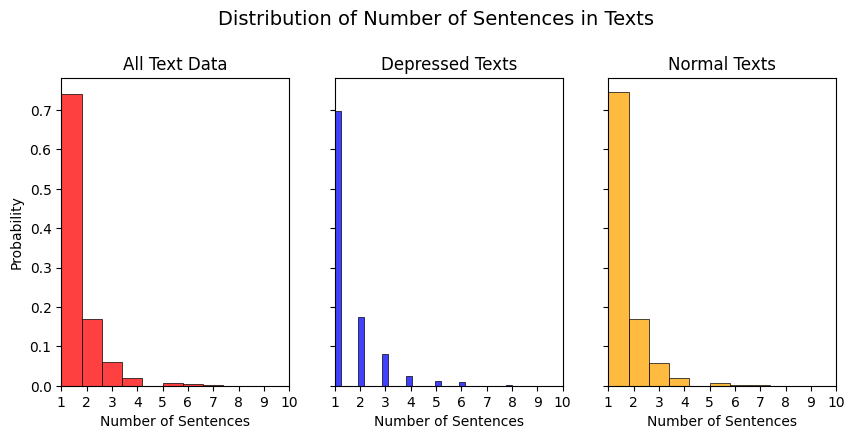

<Figure size 600x400 with 0 Axes>

In [11]:
# Create subplots for visualizing distributions
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
ax = ax.flatten()

# Set the overall title for the plots
plt.suptitle("Distribution of Number of Sentences in Texts", fontsize=14, y=1.05)

# Plot the distribution of sentence counts
plt.figure(figsize=(6, 4))
sns.histplot(
    df['n_sentences'],
    ax=ax[0],
    stat='probability',
    bins=30,
    color='red')

ax[0].set_title("All Text Data", fontsize=12)
ax[0].set_xlabel("Number of Sentences", fontsize=10)
ax[0].set_ylabel("Probability", fontsize=10)
ax[0].set_xlim(1, 10)
ax[0].set_xticks(np.arange(1, 11, 1))

# Plot the distribution of sentence counts in depressed text
sns.histplot(
    df[df['label'] == 1]['n_sentences'],
    ax=ax[1],
    bins=30,
    stat='probability',
    color='blue'
)
ax[1].set_title("Depressed Texts", fontsize=12)
ax[1].set_xlabel("Number of Sentences", fontsize=10)
ax[1].set_ylabel("Probability", fontsize=10)
ax[1].set_xticks(np.arange(1, 11, 1))
ax[1].set_xlim(1, 10)

# Plot the distribution of sentence counts in normal text
sns.histplot(
    df[df['label'] == 0]['n_sentences'],
    ax=ax[2],
    bins=30,
    stat='probability',
    color='orange',
)
ax[2].set_title("Normal Texts", fontsize=12)
ax[2].set_xlabel("Number of Sentences", fontsize=10)
ax[2].set_xticks(np.arange(1, 11, 1))
ax[2].set_xlim(1, 10);

#### Observations on Sentence Counts:
- The majority of the texts (**>5000**) consist of only **1 sentence**, while a smaller proportion contain up to **7 sentences**.
- The distribution of sentence counts appears to be **similar** between depressed and normal texts.


### Word Count Distribution in Text Data

In [12]:
# Define a function to count number of words in a text
def count_words(text):
    '''tokenize each text into words after removing the puntuation and returns number of sentences'''
    text = re.sub(r'[^\w\s]', '', text)
    words = nltk.word_tokenize(text)
    return len(words)

In [13]:
# Apply count_sentences function to 'text' column to compute sentence count
df['n_words'] = df['text'].apply(count_words)

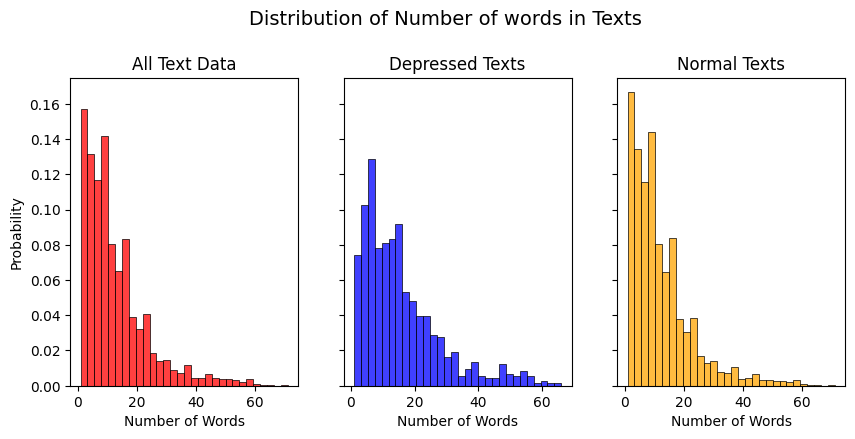

<Figure size 600x400 with 0 Axes>

In [14]:
# Create subplots for visualizing distributions
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
ax = ax.flatten()

# Set the overall title for the plots
plt.suptitle("Distribution of Number of words in Texts", fontsize=14, y=1.05)

# Plot the distribution of sentence counts
plt.figure(figsize=(6, 4))
sns.histplot(
    df['n_words'],
    ax=ax[0],
    stat='probability',
    bins=30,
    color='red')

ax[0].set_title("All Text Data", fontsize=12)
ax[0].set_xlabel("Number of Words", fontsize=10)
ax[0].set_ylabel("Probability", fontsize=10)

# Plot the distribution of word counts in depressed text
sns.histplot(
    df[df['label'] == 1]['n_words'],
    ax=ax[1],
    bins=30,
    stat='probability',
    color='blue'
)
ax[1].set_title("Depressed Texts", fontsize=12)
ax[1].set_xlabel("Number of Words", fontsize=10)
ax[1].set_ylabel("Probability", fontsize=10)


# Plot the distribution of sentence counts in normal text
sns.histplot(
    df[df['label'] == 0]['n_words'],
    ax=ax[2],
    bins=30,
    stat='probability',
    color='orange',
)
ax[2].set_title("Normal Texts", fontsize=12)
ax[2].set_xlabel("Number of Words", fontsize=10);


#### Observation:

Depressed text entries generally exhibit a **lower word count** compared to normal text entries, indicating that depressed texts tend to be shorter in length.

In [15]:
# Identify the text with the highest word count ( done out of curiosity)
max_num_words = df['n_words'].max()
longest_sentence = df.loc[df['n_words'].idxmax(), 'text']
label_longest_sentence = df.loc[df['n_words'].idxmax(), 'label']

# Print the longest sentence and its word count
print(f"The longest sentence has {max_num_words} words.")
print("\nLongest Sentence:\n", longest_sentence)
print("\nLongest Sentence label is:", label_longest_sentence)

The longest sentence has 71 words.

Longest Sentence:
 [Cm] guys, I'm in smt 6 and I'm an intern, have the privilege to be able to go to s2 starting from smt 7, so I graduated from smt 9 already finished s2. It's time and cost-effective (I don't have any problems with costs). But I'm confused whether to take it or not, as long as master's degree can't be while working, you have to go to full college. Tp (cont)

Longest Sentence label is: 0


## Text Preprocessing for Data Exploration and Numerical Representation of Text
The preprocessing steps include the following:  
- Converting text to **lowercase** to ensure data consistency.  
- Removing **punctuation** to clean the data.  
- Applying **lemmatization** to reduce words to their roots.
- Remove **stop words**

In [16]:
# find stop words in english
stop_words = nltk.corpus.stopwords.words('english')
print("Some stop words in English:\n",stop_words[:30])

Some stop words in English:
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself']


In [17]:
# Initialize Lemmatizer from nltk
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define a preprocessing function
def preprocess_text(text):
    """
    Preprocess the input text:
    - Convert to lowercase
    - Remove punctuation
    - Remove stopwords
    - Tokenize at word level
    - Apply lemmatization
    """
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove stopwords
    words_without_stopwords = [
        word for word in text.split() if word not in stop_words
    ]

    # Tokenize at word level
    word_tokens = nltk.word_tokenize(' '.join(words_without_stopwords))

    # Lemmatize tokens
    lemmatized_words = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])

    return lemmatized_words

# Apply preprocessing to the 'text' column of the DataFrame
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Display the first few rows of the DataFrame
df.head()


,text,label,n_sentences,n_words,cleaned_text
0,oh my gosh,1,1,3,oh gosh
1,"trouble sleeping, confused mind, restless hear...",1,2,10,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",1,2,14,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,1,1,11,shifted focus something else still worried
4,"I'm restless and restless, it's been a month n...",1,2,14,restless restless month boy mean


### The Most Frequent Words in Depressed Texts


In [18]:
def create_word_freq_dict(my_word_list):
    """
    Creates a frequency dictionary of words from the input word list.

    Parameters:
        my_word_list (list): A list of words to count.

    Returns:
        dict: A dictionary with words as keys and their frequencies as values.
    """
    word_freq_dict = {}

    for word in my_word_list:
        word_freq_dict[word] = word_freq_dict.get(word, 0) + 1

    return word_freq_dict

### Generate Word Lists for Depressed and Normal Texts, and Calculate Vocabulary Size

In [19]:
# Create lists for the words in depressed texts and normal texts
# Extract clean text and flatten the words list using 'explode()'
all_words_depressed_text = df[df['label'] == 1]['cleaned_text'].str.split().explode().dropna().tolist()
all_words_normal_text = df[df['label'] == 0]['cleaned_text'].str.split().explode().dropna().tolist()

# Combine all words from depressed and normal texts (after preprocessing, e.g., punctuation removal)
# The size of the vocabulary is crucial when converting text into numerical representations
all_words = all_words_depressed_text + all_words_normal_text

# Extract unique words and calculate the vocabulary size
all_unique_words = set(all_words)
n_unique_words = len(all_unique_words)

# Display the total number of unique words
print(f"Vocabulary size (unique words in the dataset): {n_unique_words}")


Vocabulary size (unique words in the dataset): 10966


### Visualizing Words in Depressed and Normal Text

In this section, we visualize the most frequent words in both the depressed and normal text datasets using word clouds. This visualization highlights the predominant themes and vocabulary in each category, offering valuable insights into the linguistic characteristics associated with depressive language compared to normal language. Such analysis aids in better understanding of the data.


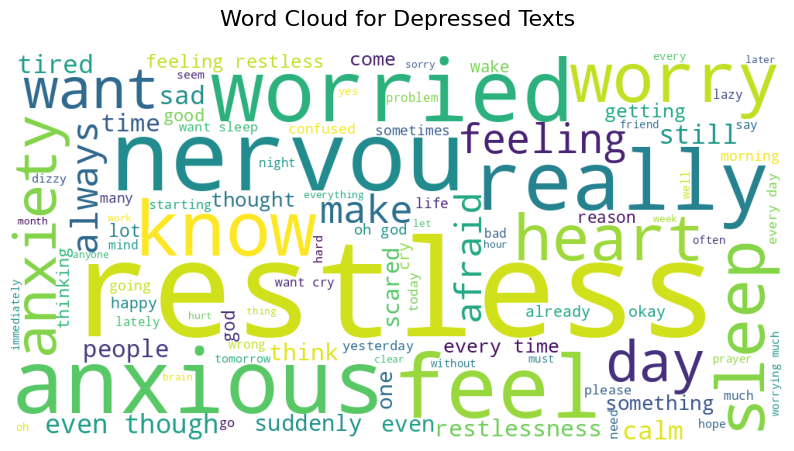

In [20]:
# Combine all words from depressed text into a single string
words_depressed = ' '.join(all_words_depressed_text)

# Create the word cloud
wordcloud_depressed = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    max_words=100).generate(words_depressed)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_depressed)
plt.axis('off')
plt.title('Word Cloud for Depressed Texts', fontsize=16, y=1.05)
plt.show()

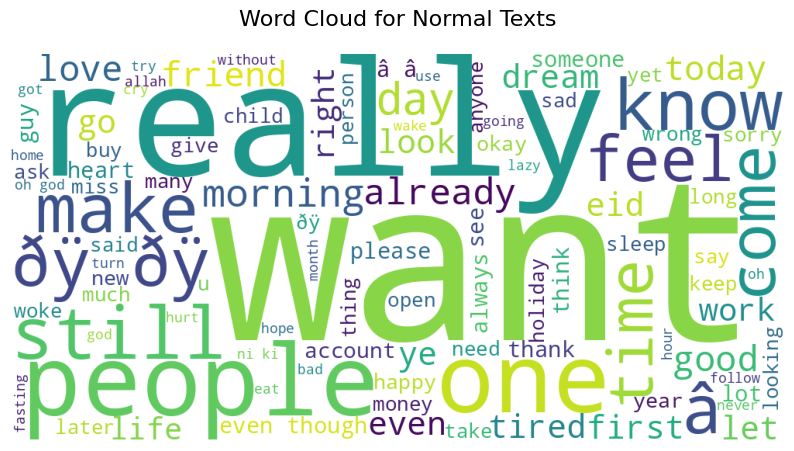

In [21]:
# Combine all words from normal text into a single string
words_normal = ' '.join(all_words_normal_text)

# Create the word cloud
wordcloud_normal = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    max_words=100).generate(words_normal)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_normal)
plt.axis('off')
plt.title('Word Cloud for Normal Texts', fontsize=16, y=1.05)
plt.show()

#### Visualizing and Quantifying the Most Frequent Words in the Dataset

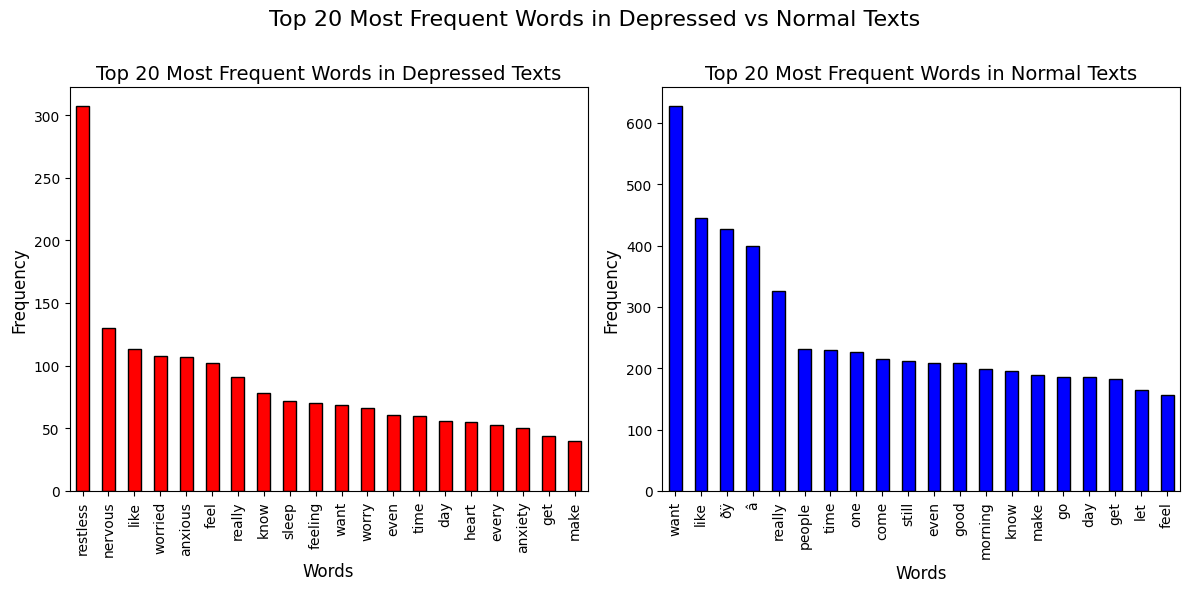

In [22]:
# Create dictionaries for word frequencies in depressed and normal texts
depressed_text_word_dict = create_word_freq_dict(all_words_depressed_text)
normal_text_word_dict = create_word_freq_dict(all_words_normal_text)

# Convert the word frequency dictionaries to Pandas Series and sort them by frequency (in descending order)
depressed_word_frequencies = pd.Series(depressed_text_word_dict).sort_values(ascending=False)
normal_word_frequencies = pd.Series(normal_text_word_dict).sort_values(ascending=False)

# Plot the top 20 most frequent words and their frequencies
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the top 20 frequent words for depressed texts
depressed_word_frequencies.head(20).plot(kind='bar', ax=ax[0], color='red', edgecolor='black')
ax[0].set_title("Top 20 Most Frequent Words in Depressed Texts", fontsize=14)
ax[0].set_xlabel("Words", fontsize=12)
ax[0].set_ylabel("Frequency", fontsize=12)


# Plot the top 20 frequent words for normal texts
normal_word_frequencies.head(20).plot(kind='bar', ax=ax[1], color='blue', edgecolor='black')
ax[1].set_title("Top 20 Most Frequent Words in Normal Texts", fontsize=14)
ax[1].set_xlabel("Words", fontsize=12)
ax[1].set_ylabel("Frequency", fontsize=12)

# Set the overall title for the plots
plt.suptitle("Top 20 Most Frequent Words in Depressed vs Normal Texts", fontsize=16)

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


#### Observations:
- **Depressed text** contains words that are commonly associated with negative emotions, such as **restless**, **nervous**, and **worried**.
- Both **depressed** and **normal** texts share some frequent words, including **want**, **like**, and **feel**, which are often used in general communication.


# Section 2

## Converting Text into Numerical Representations

## Approach 1: TF-IDF

In this project, one approach to convert text into numerical data is **TF-IDF**. This method is chosen due to its following advantages:

- **Focus on Relevant Words**: TF-IDF emphasizes the most significant words in depressed and normal texts by assigning weights based on their importance.  
- **Improved Clustering**: By highlighting the most significant words in each category, I hope that TF-IDF enables the creation of accurate and meaningful clusters.


### Create TF-IDF matrix

In [23]:
# Apply a TF-IDF vectorizer to transform text data
n_features = 500  # Limit the number of features for interpretability
tfidf_vectorizer = TfidfVectorizer(
    max_features=n_features,
    stop_words='english',
       lowercase=True)
# Transform the text data into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Output the shape of the resulting TF-IDF matrix
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape} (Documents x Features)")

# Display the first 100 feature names (words)
print("Sample of TF-IDF Feature Names:")
print(tfidf_vectorizer.get_feature_names_out()[:100])

TF-IDF Matrix Shape: (6970, 500) (Documents x Features)
Sample of TF-IDF Feature Names:
['00' '02' '10' '100' '11' '12' '2021' '25' '30' '71' 'able' 'acc'
 'account' 'actually' 'afraid' 'afternoon' 'age' 'ah' 'al' 'album'
 'alhamdulillah' 'allah' 'angry' 'annoying' 'answer' 'anxiety' 'anxious'
 'anymore' 'area' 'arrived' 'ask' 'asked' 'asking' 'assignment' 'au'
 'away' 'baby' 'bad' 'bank' 'beautiful' 'believe' 'best' 'better' 'big'
 'birthday' 'bismillah' 'bit' 'blah' 'body' 'book' 'bored' 'bot' 'boy'
 'boyfriend' 'brain' 'break' 'bring' 'bro' 'brother' 'btw' 'busy' 'buy'
 'cake' 'called' 'calm' 'came' 'car' 'care' 'case' 'cat' 'cb' 'cellphone'
 'change' 'chat' 'check' 'child' 'choose' 'class' 'clean' 'clear' 'clock'
 'close' 'clothes' 'cold' 'college' 'come' 'comeback' 'comfortable'
 'coming' 'como' 'complain' 'confused' 'content' 'continue' 'cool' 'cover'
 'covid' 'crazy' 'cute' 'damn']


#### Observations:
 - The TF-IDF vectorizer built a vocabulary consisting of the top `max_features` terms, ordered by term frequency across the corpus.  
- Although the total number of unique words in the dataset is approximately **11,000**, the maximum number of features was limited to **500** to reduce dimensionality and computational complexity.  


### Converting TF-IDF Matrix to a DataFrame with Text Labels

In [24]:
# Convert the TF-IDF matrix to a DataFrame and include the feature names
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

# Add the labels column to the DataFrame
tfidf_df['label'] = df['label'].values

# Display the first 10 rows of the resulting DataFrame
print("TF-IDF DataFrame with Labels:\n")
print(tfidf_df.head(10))


TF-IDF DataFrame with Labels:

    00   02   10  100   11   12  2021   25   30   71  ...  young  zonaba  \
0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0     0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0     0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0     0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0     0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0     0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0     0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0     0.0   
7  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0     0.0   
8  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0     0.0   
9  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0     0.0   

   zonauang  ºðÿ   âœ   ìž   ðÿ  ƒðÿ   ˆì  label  
0       0.0  0.0  0.0  0.0  0.0  0.0  0.0      1  
1       0.0  0.0  0.0  0.0  0.

#### Observations:
- The **TF-IDF vectorizer** produces a high-dimensional sparse matrix.
- **PCA (Principal Component Analysis)** will be applied for dimensionality reduction, simplifying the dataset while retaining key information.  


### Visualization of TF-IDF Data in PCA-Reduced Dimensions

Explained Variance by each component: [0.02 0.01]
Total Explained Variance: 0.03


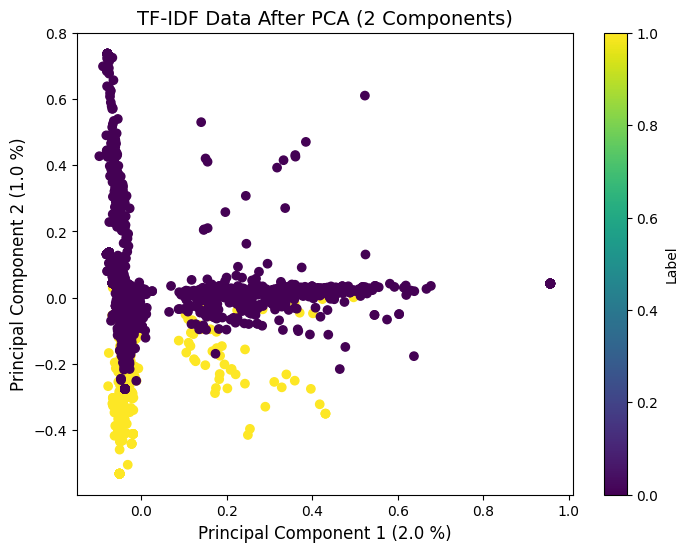

In [25]:
# Define the number of principal components
n_components = 2

# Apply PCA to the TF-IDF matrix
pca = PCA(n_components=n_components)
tfidf_pca = pca.fit_transform(tfidf_df.drop(['label'],axis=1))

# Check the explained variance ratio to understand the data retained
explained_variance = np.round(pca.explained_variance_ratio_,2)
print(f"Explained Variance by each component: {explained_variance}")
print(f"Total Explained Variance: {explained_variance.sum()}")

# Create a scatter plot to visualize the reduced data
plt.figure(figsize=(8, 6))
plt.scatter(
    tfidf_pca[:, 0], tfidf_pca[:, 1],
    c=tfidf_df['label'])

plt.title("TF-IDF Data After PCA (2 Components)", fontsize=14)
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100} %)", fontsize=12)
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100} %)", fontsize=12)
plt.colorbar(label="Label")
plt.show()


#### Observations:
In the PCA-reduced space, two distinct clusters emerge, though some overlap is observed, indicating partial separability between the depressed and normal text data.


### Applying K-Means Clustering to TF-IDF Data

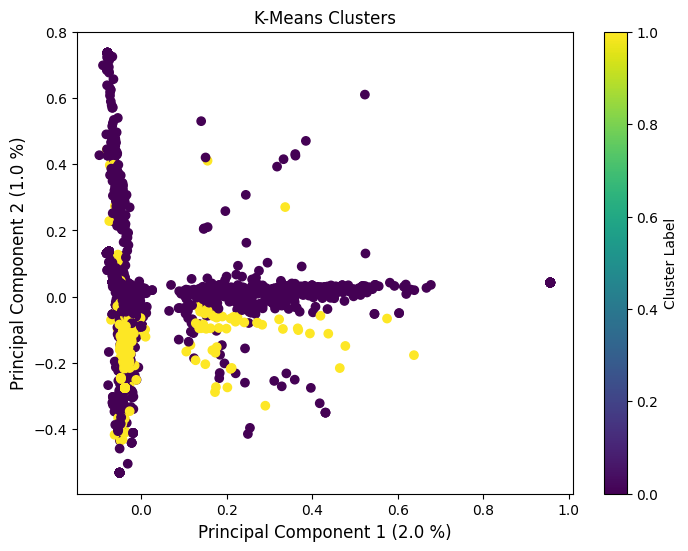

In [26]:
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(tfidf_df.drop(columns=['label'], axis=1))

# Add the clustering result to the DataFrame
df['k_means_clusters'] = kmeans_labels


# Reduce dimensions to 2D by PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_df.drop(columns=['label'],axis=0))
explained_variance = np.round(pca.explained_variance_ratio_,2)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels)
plt.title('K-Means Clusters')
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100} %)", fontsize=12)
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100} %)", fontsize=12)
plt.colorbar(label='Cluster Label')
plt.show()



#### Observations:
The visual exploration indicates that applying **K-Means clustering** to the **TF-IDF data** has not been very successful. The resulting clusters do not show clear separation, suggesting that K-Means may not be the most effective clustering algorithm for this dataset in its current form.


### Quantitative Assessment of K-Means Clustering on TF-IDF Data

In [27]:
# Adjusted Rand Index
ari_score = np.round(adjusted_rand_score(df['label'], df['k_means_clusters']), 3)

# Normalized Mutual Information
nmi_score = np.round(normalized_mutual_info_score(df['label'], df['k_means_clusters']),3)

# Print the assessment scores
print(f"Adjusted Rand Index (ARI): {ari_score}")
print(f"Normalized Mutual Information (NMI): {nmi_score}")


Adjusted Rand Index (ARI): 0.055
Normalized Mutual Information (NMI): 0.007


#### Observations:
- As the **ARI (Adjusted Rand Index)** score is very low, it indicates that K-Means clustering performs **random clustering**.
- The **NMI (Normalized Mutual Information)** score also supports this finding, confirming that the clustering results are not closely aligned with the true labels.
- Given that the TF-IDF data is highly sparse, I plan to apply **K-Means clustering after dimensionality reduction using PCA**. PCA will help extract latent semantic relationships from the TF-IDF data, reducing the dimensionality and capturing the most significant components, which may improve clustering performance.


### Applying PCA and Then K-Means Clustering on TF-IDF Data

1. **Apply PCA**:  
   - Reduce the TF-IDF data to dimensions ranging from 2 to 10 using PCA.  

2. **Apply K-Means Clustering**:  
   - Perform clustering on the PCA-transformed data for each dimensionality.  
   - Evaluate and compare performance to determine the optimal number of components.


In [28]:
results = []  # To store adjusted rand scores for each PCA dimension
num_clusters = 2
pca_dimensions = np.arange(2, 11)
for num_components in pca_dimensions:
    # Apply dimensionality reduction for different number of components
    pca = PCA(n_components=num_components)
    reduced_data = pca.fit_transform(tfidf_df.drop(['label'],axis=1))
    total_explained_variance_percent = np.round(np.sum(pca.explained_variance_ratio_)*100)

    # fit kMeans algorithm to reduced TF-IDF ata
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_data)

    # Evaluate using adjusted_rand_score
    ari_score = np.round(adjusted_rand_score(df['label'], cluster_labels), 3)

    # Store results
    results.append({
        "n_pca_components": num_components,
        "adjusted_rand_score": ari_score,
        "total_explain_variance":total_explained_variance_percent
    })

# Step 3: Display Results
results_df = pd.DataFrame(results)
print(results_df)

   n_pca_components  adjusted_rand_score  total_explain_variance
0                 2               -0.021                     3.0
1                 3               -0.021                     5.0
2                 4               -0.019                     6.0
3                 5               -0.020                     7.0
4                 6               -0.025                     8.0
5                 7               -0.020                     9.0
6                 8                0.275                    10.0
7                 9               -0.019                    11.0
8                10               -0.019                    12.0


#### Observations:
- **K-Means clustering** still does not perform well, even after applying it to the **PCA-reduced space**. This suggests that the dimensionality reduction did not significantly improve the clustering results, and the inherent sparsity of the TF-IDF data may be a limiting factor.


### Applying K-Medoids Clustering to TF-IDF Data

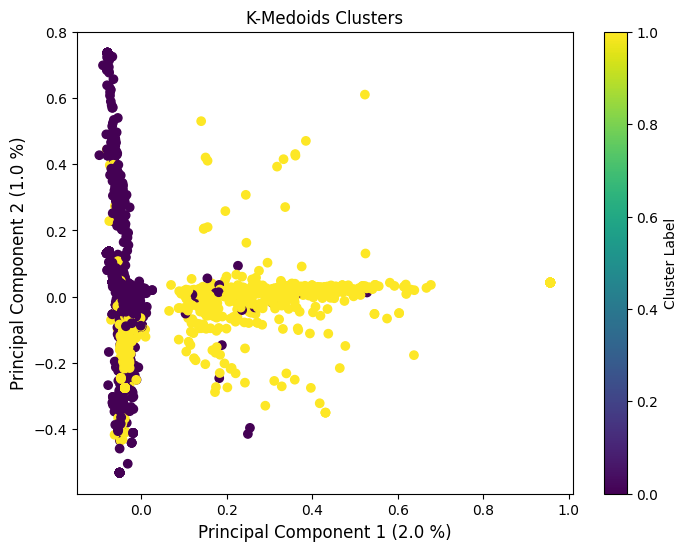

In [29]:
num_clusters = 2
kmedoids = KMedoids(n_clusters=num_clusters, random_state=42, metric='cosine')

kmedoids_labels = kmedoids.fit_predict(tfidf_df.drop(columns=['label'], axis=1))

# Add the clustering result to the DataFrame
df['k_medoids_clusters'] = kmedoids_labels

# Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_df.drop(columns=['label'],axis=1))
explained_variance = np.round(pca.explained_variance_ratio_,2)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmedoids_labels)
plt.title('K-Medoids Clusters')
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100} %)", fontsize=12)
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100} %)", fontsize=12)
plt.colorbar(label='Cluster Label')
plt.show()


### Quantitative Assessment of K-Medoids Clustering on TF-IDF Data

In [30]:
# Adjusted Rand Index
ari_score = np.round(adjusted_rand_score(df['label'], df['k_medoids_clusters']), 3)

# Normalized Mutual Information
nmi_score = np.round(normalized_mutual_info_score(df['label'],df['k_medoids_clusters']),3)

# Print the assessment scores
print(f"Adjusted Rand Index (ARI): {ari_score}")
print(f"Normalized Mutual Information (NMI): {nmi_score}")

Adjusted Rand Index (ARI): 0.019
Normalized Mutual Information (NMI): 0.001


### Observation:
K-Medoids clustering was unable to effectively separate depressed and normal text when using the TF-IDF representation of the data.


### Applying PCA and Then K-Medoids Clustering on TF-IDF Data

1. **Apply PCA**:  
   - Reduce the TF-IDF data to dimensions ranging from 2 to 10 using PCA.  

2. **Apply K-Medoids Clustering**:  
   - Perform clustering on the PCA-transformed data for each dimensionality.  
   - Evaluate and compare performance to determine the optimal number of components.

In [31]:
results = []  # To store adjusted rand scores for each PCA dimension
num_clusters = 2
pca_dimensions = np.arange(2, 11)
for num_components in pca_dimensions:
    # Apply dimensionality reduction for different number of components
    pca = PCA(n_components=num_components)
    reduced_data = pca.fit_transform(tfidf_df.drop(['label'],axis=1))
    total_explained_variance_percent = np.round(np.sum(pca.explained_variance_ratio_)*100)

    # fit kMedoids algorithm to reduced TF-IDF data
    kmedoids = KMedoids(n_clusters=num_clusters, random_state=42, metric='cosine')
    kmedoids_labels = kmedoids.fit_predict(reduced_data)

    # Evaluate using adjusted_rand_score
    ari_score = np.round(adjusted_rand_score(df['label'],  kmedoids_labels), 3)

    # Store results
    results.append({
        "n_pca_components": num_components,
        "adjusted_rand_score": ari_score,
        "total_explain_variance":total_explained_variance_percent
    })

# Step 3: Display Results
results_df = pd.DataFrame(results)
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


   n_pca_components  adjusted_rand_score  total_explain_variance
0                 2                0.219                     3.0
1                 3                0.199                     5.0
2                 4                0.172                     6.0
3                 5                0.048                     7.0
4                 6                0.150                     8.0
5                 7                0.163                     9.0
6                 8                0.000                    10.0
7                 9               -0.000                    11.0
8                10                0.110                    12.0


### Observations:

- **K-Medoids Clustering** performs better when applied to the PCA-reduced space, indicating that dimensionality reduction slightly improves clustering results.
- Additionally, **K-Medoids** outperforms **K-Means** in this context.
- A adjusted rand score of ~0.2 indicates some positive agreement, but it is quite weak. This suggests that the clustering algorithm is identifying some patterns, but it struggles to accurately match the true groupings.

## Approach 2. Converting Text into Numerical Representations Using SpaCy

In [32]:
# Load the pre-trained spaCy model
nlp = spacy.load("en_core_web_lg")

# Function to extract the spaCy document vector
def get_spacy_vector(text):
    """
    Converts a text input into its corresponding spaCy vector representation.

    Parameters:
    - text (str): The input text.

    Returns:
    - numpy.ndarray: A vector representation of the text.
    """
    doc = nlp(text)
    return doc.vector

# Apply the function to generate vectorized features
df['spacy_vector'] = df['cleaned_text'].apply(get_spacy_vector)

# Display a sample of the updated DataFrame
print("DataFrame with spaCy Vectors:")
print(df[['cleaned_text', 'spacy_vector']].head())

DataFrame with spaCy Vectors:
                                        cleaned_text  \
0                                            oh gosh   
1  trouble sleeping confused mind restless heart ...   
2  wrong back dear forward doubt stay restless re...   
3         shifted focus something else still worried   
4                   restless restless month boy mean   

                                        spacy_vector  
0  [4.5306, -2.99935, -1.71405, -2.42265, -2.4224...  
1  [1.8508843, 1.3744242, -3.2077413, -1.910793, ...  
2  [1.176421, 2.1058412, -2.2963457, -0.3238889, ...  
3  [0.046608254, 3.0461, -2.6498668, -0.91707605,...  
4  [0.446858, 1.692106, -2.331416, -2.0845459, -0...  


In [33]:
# Convert the list of vectors into a feature matrix
df_spacy_vectors = pd.DataFrame(df['spacy_vector'].tolist())

# Add the label column to the new DataFrame
df_spacy_vectors['label'] = df['label']

# Display information about the DataFrame structure and data types
print("DataFrame Info (with spaCy vectors):")
df_spacy_vectors.info()

# Display the first 10 rows of the resulting DataFrame
print("\nDataFrame consisting of vectors obtained from spaCy (first 10 rows):")
print(df_spacy_vectors.head(10))

DataFrame Info (with spaCy vectors):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6970 entries, 0 to 6969
Columns: 301 entries, 0 to label
dtypes: float32(300), int64(1)
memory usage: 8.0 MB

DataFrame consisting of vectors obtained from spaCy (first 10 rows):
          0         1         2         3         4         5         6  \
0  4.530600 -2.999350 -1.714050 -2.422650 -2.422450  3.318600 -2.077950   
1  1.850884  1.374424 -3.207741 -1.910793 -0.346586 -0.541699  2.047407   
2  1.176421  2.105841 -2.296346 -0.323889  0.804174  2.871890  1.080743   
3  0.046608  3.046100 -2.649867 -0.917076  0.746273  0.024108  1.878678   
4  0.446858  1.692106 -2.331416 -2.084546 -0.496000 -0.437678  1.161346   
5  0.183373  1.558486 -2.778313 -1.371421  0.676423  0.688897  2.109713   
6  0.108924  2.286146 -2.826424 -3.095650  0.293841  0.346851  0.953241   
7 -1.217612  1.364542 -1.753708 -2.633325 -1.597280 -1.011590  1.870637   
8 -0.592790 -1.529296 -1.838343  1.021294  1.452021 -0.9406

### PCA Reduction of spaCy Vectors

Explained Variance by Each Component: [14.65  8.79]%
Total Explained Variance: 23.440000534057617%


Text(0, 0.5, 'Principal Component 2')

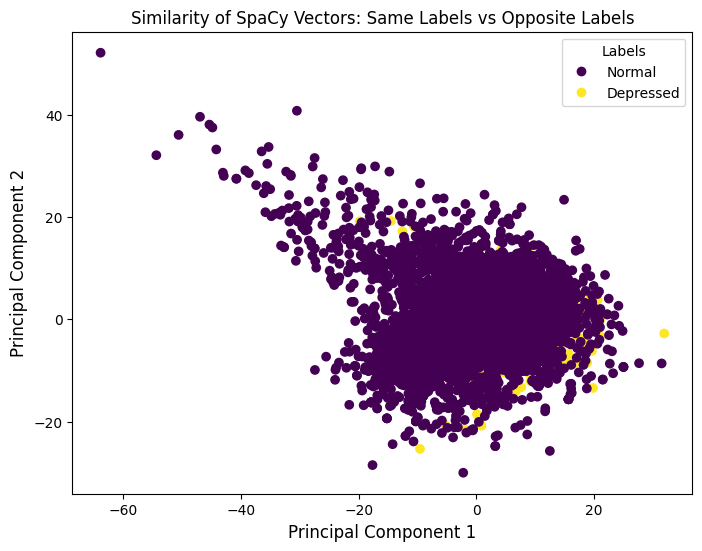

In [34]:
## Define the number of principal components
n_components = 2

# Apply PCA to the spaCy vector data (excluding the label column)
pca = PCA(n_components=n_components)
spacy_vectors_pca = pca.fit_transform(df_spacy_vectors.drop(columns=['label'], axis=1))

# Calculate and display the explained variance ratio
explained_variance = np.round(pca.explained_variance_ratio_ * 100, 2)  # Convert to percentage
total_explained_variance = np.round(explained_variance.sum(),2)
print(f"Explained Variance by Each Component: {explained_variance}%")
print(f"Total Explained Variance: {total_explained_variance}%")

# Create a scatter plot to visualize the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    spacy_vectors_pca[:, 0], spacy_vectors_pca[:, 1],
    c=df_spacy_vectors['label'])


plt.legend(handles=scatter.legend_elements()[0], labels=["Normal", "Depressed"], title="Labels")
plt.title("Similarity of SpaCy Vectors: Same Labels vs Opposite Labels")
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)


### Observations:
In the PCA-reduced space, clear clusters are not detectable, suggesting that the first two principal components may not capture sufficient information to separate the classes effectively. This indicates that more complex techniques or additional dimensions might be necessary for optimal clustering.


### LDA Reduction of spaCy Vectors

Explained Variance Ratio: [1.]
Total Explained Variance: 1.0


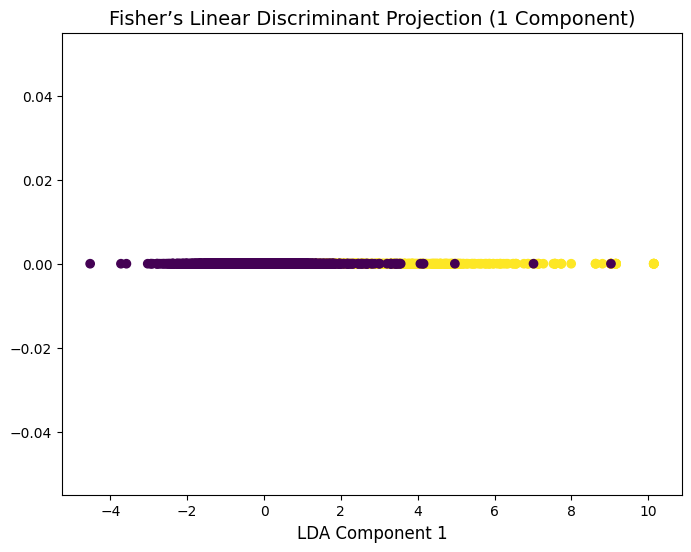

In [35]:
n_components = 1  # Set to the number of classes minus one for maximum separability

# Initialize LDA and fit-transform the data
lda = LDA(n_components=n_components)
lda_components = lda.fit_transform(df_spacy_vectors.drop(['label'], axis=1), df_spacy_vectors['label'])

# Display explained variance ratio
explained_variance = lda.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")
print(f"Total Explained Variance: {explained_variance.sum()}")


plt.figure(figsize=(8, 6))
plt.scatter(lda_components, [0] * len(lda_components), c=df_spacy_vectors['label'])
plt.title("Fisher’s Linear Discriminant Projection (1 Component)", fontsize=14)
plt.xlabel("LDA Component 1", fontsize=12)

plt.show()


### Observations:

- In the LDA-reduced space, distinct clusters are identifiable, although some overlap between points exists.  
- In the next step, I will apply clustering to both the original spaCy vectors and the LDA-reduced spaCy vectors.


### Applying K-Medoids Clustering to spaCy vectors

Explained variance by first PCA component: 14.65
Explained variance by second PCA component: 8.79


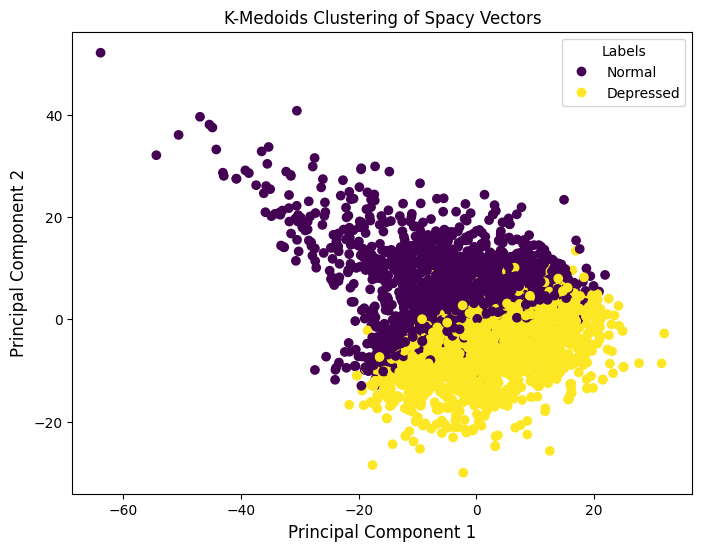

In [36]:
num_clusters = 2
kmedoids = KMedoids(n_clusters = num_clusters, random_state=42, metric='cosine')

kmedoids_labels_spacy_vectors  = kmedoids.fit_predict(df_spacy_vectors.drop(columns=['label'], axis=1))

# Add the clustering result to the DataFrame
df['k_medoids_clusters_spacy_vectors'] = kmedoids_labels_spacy_vectors


# Visualize the clusters using PCA
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_spacy_vectors.drop(columns=['label'],axis=1))
explained_variance = pca.explained_variance_ratio_
pca_1_explained_variance = np.round(explained_variance[0] *100, 2)
pca_2_explained_variance = np.round(explained_variance[1] *100, 2)
print("Explained variance by first PCA component:", pca_1_explained_variance)
print("Explained variance by second PCA component:", pca_2_explained_variance)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmedoids_labels_spacy_vectors)
plt.legend(handles=scatter.legend_elements()[0], labels=["Normal", "Depressed"], title="Labels")
plt.title('K-Medoids Clustering of Spacy Vectors')
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.show()

### Quantitative Assessment of K-Medoids Clustering on spaCy vectors

In [37]:
# Adjusted Rand Index
ari_score = np.round(adjusted_rand_score(df['label'], df['k_medoids_clusters_spacy_vectors']), 3)

# Normalized Mutual Information
nmi_score = np.round(normalized_mutual_info_score(df['label'],df['k_medoids_clusters_spacy_vectors']),3)

# Print the assessment scores
print(f"Adjusted Rand Index (ARI): {ari_score}")
print(f"Normalized Mutual Information (NMI): {nmi_score}")

Adjusted Rand Index (ARI): -0.001
Normalized Mutual Information (NMI): 0.006


### Observation:
The K-Medoids clustering method failed to separate depressed and normal text when represented by spaCy vectors, as indicated by the low Adjusted Rand Index and Normalized Mutual Information.


### K-Medoids Clustering of LDA-Reduced SpaCy Vectors

Text(0.5, 0, 'LDA Component 1')

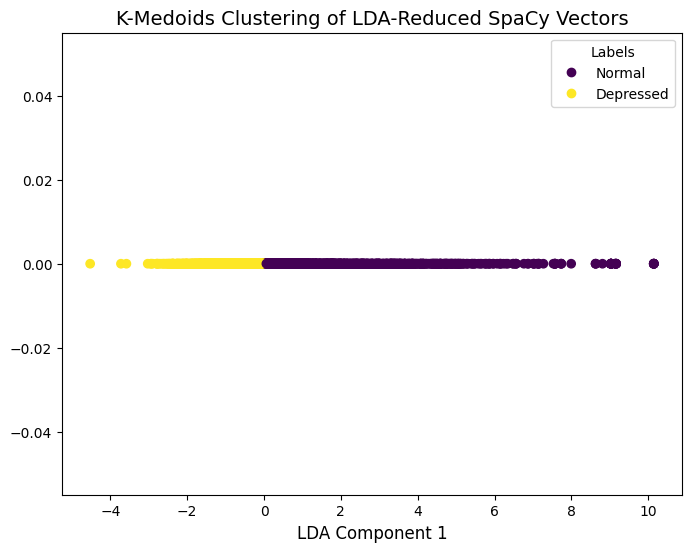

In [38]:
num_clusters = 2
kmedoids = KMedoids(n_clusters=num_clusters, init='random', random_state=42, metric='cosine')

kmedoids_labels_reduced_spacy_vectors  = kmedoids.fit_predict(lda_components)

# Add the clustering result to the DataFrame
df['k_medoids_clusters_reduced_spacy_vectors'] = kmedoids_labels_reduced_spacy_vectors


plt.figure(figsize=(8, 6))
plt.scatter(lda_components, [0] * len(lda_components), c=df['k_medoids_clusters_reduced_spacy_vectors'])
plt.legend(handles=scatter.legend_elements()[0], labels=["Normal", "Depressed"], title="Labels")
plt.title("K-Medoids Clustering of LDA-Reduced SpaCy Vectors", fontsize=14)
plt.xlabel("LDA Component 1", fontsize=12)


#### Quantitative Assessment of K-Medoids Clustering on LDA-reduced spaCy vectors

In [39]:
# Adjusted Rand Index
ari_score = np.round(adjusted_rand_score(df['label'], df['k_medoids_clusters_reduced_spacy_vectors']), 3)

# Normalized Mutual Information
nmi_score = np.round(normalized_mutual_info_score(df['label'],df['k_medoids_clusters_reduced_spacy_vectors']),3)

# Print the assessment scores
print(f"Adjusted Rand Index (ARI): {ari_score}")
print(f"Normalized Mutual Information (NMI): {nmi_score}")

Adjusted Rand Index (ARI): 0.218
Normalized Mutual Information (NMI): 0.233


### Observation:

Although **K-Medoids** clustering performs better on **LDA-reduced spaCy vectors** compared to the original high-dimensional **spaCy vectors**, the algorithm still struggles to accurately identify the data points. This is evident from the low **Adjusted Rand Index** and **Normalized Mutual Information**, which indicate poor clustering performance.


### Gaussian Mixture Model Clustering on LDA-Reduced SpaCy Vectors

Text(0.5, 0, 'LDA Component 1')

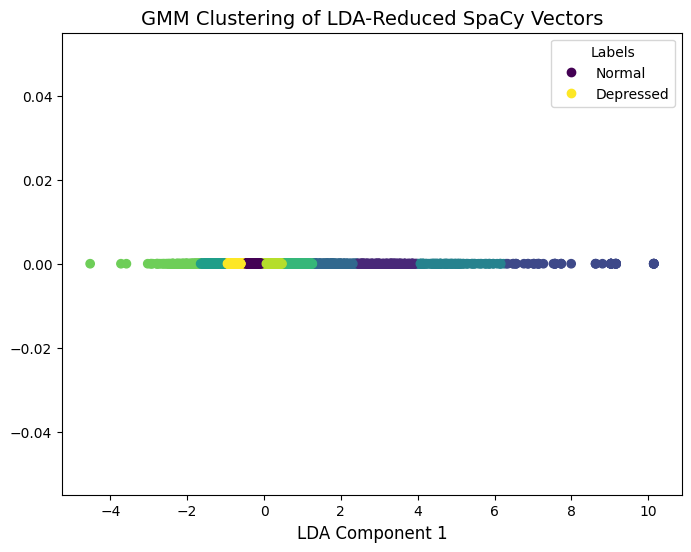

In [40]:
num_clusters = 2
gmm = GaussianMixture(n_components=num_components, covariance_type='full', random_state=42)
gmm_labels_reduced_spacy_vectors =gmm.fit_predict(lda_components)

# Add the clustering result to the DataFrame
df['gmm_labels_reduced_spacy_vector'] = gmm_labels_reduced_spacy_vectors

plt.figure(figsize=(8, 6))
plt.scatter(lda_components, [0] * len(lda_components), c=df['gmm_labels_reduced_spacy_vector'])
plt.legend(handles=scatter.legend_elements()[0], labels=["Normal", "Depressed"], title="Labels")
plt.title("GMM Clustering of LDA-Reduced SpaCy Vectors", fontsize=14)
plt.xlabel("LDA Component 1", fontsize=12)


#### Quantitative Assessment of GMM Clustering on LDA-reduced spaCy vectors

In [41]:
# Adjusted Rand Index
ari_score = np.round(adjusted_rand_score(df['label'], df['gmm_labels_reduced_spacy_vector']), 3)

# Normalized Mutual Information
nmi_score = np.round(normalized_mutual_info_score(df['label'],df['gmm_labels_reduced_spacy_vector']),3)

# Print the assessment scores
print(f"Adjusted Rand Index (ARI): {ari_score}")
print(f"Normalized Mutual Information (NMI): {nmi_score}")

Adjusted Rand Index (ARI): 0.08
Normalized Mutual Information (NMI): 0.197


### Observation:
GMM clustering does not perform well on the spaCy vectors after they are projected into lower dimensions using LDA.


# Conclusion

### Hypothesis:

My hypothesis is that social media posts reflect people's mental health states. By analyzing the text, I propose that posts can be categorized into two groups: **depressed** and **healthy**. During the exploratory analysis of the texts, I observed that the language used in depressed posts differs significantly from that in normal posts. For example, words like *anxiety*, *heart*, *nervous*, and *restless* are more common in depressed texts, while these words are less frequent in normal texts.

### Text Preprocessing:

After standardizing the text (removing punctuation, lowercasing, and lemmatization), the text is converted into numerical representations using four approaches:
1. **TF-IDF** (Term Frequency-Inverse Document Frequency)
   TF-IDF is a valuable technique for sentiment analysis because it highlights the most important words in a text. When combined with dimensionality reduction techniques like PCA, it can help to simplify complex data and improve clustering accuracy. 

3. **Vector representations** via the **spaCy** library
    spaCy provides pre-trained word embeddings that capture the meaning of words. These embeddings can represent entire sentences or documents, making them useful for tasks like clustering and sentiment analysis.

### Dimensionality Reduction and Clustering:

I leveraged the capabilities of **PCA** and **LDA** for dimensionality reduction and visualisation. I applied several clustering algorithms:
- **K-Means**
- **K-Medoids**
- **Gaussian Mixture Modeling (GMM)**

Clustering was performed on both the original numerical representations and their reduced forms obtained through PCA and LDA.

### Results and Challenges:
Unfortunately, the clustering methods did not align well with the actual labels, as evidenced by low scores on external clustering evaluation metrics such as the **Adjusted Rand Index** and **Normalized Mutual Information**.

I believe the primary reasons for this outcome are:
- The **random nature** of clustering algorithms
- The **imbalance** between the number of depressed and normal text samples
- The **non-spherical structure** of the underlying clusters
